<a href="https://colab.research.google.com/github/DimitriLeandro/DA2Group10/blob/main/pretrained_satellighte_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading datasets and importing libs

In [ ]:
!pip install satellighte

In [44]:
import imageio
import satellighte as sat
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torchmetrics as tm
import pytorch_lightning as pl
from pathlib import Path
from PIL import Image
from torch import flatten
from torchvision import transforms as tt
from torchvision.transforms.transforms import Resize
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
!wget -q https://uni-muenster.sciebo.de/s/KNjoOrXdWecbvdh/download?path=%2F&files=training_patches.zip
!unzip -qq /content/download?path=%2F
!unzip -qq /content/task_2/training_patches.zip
!unzip -qq /content/task_2/unlabeled_training_data.zip
!unzip -qq /content/task_2/validation_data.zip

## Mounting drive to save model checkpoints

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Loading pretrained model

In [2]:
sat.available_models()

['efficientnet_b0_eurosat', 'mobilenetv2_default_eurosat']

In [77]:
model_name = 'mobilenetv2_default_eurosat'
model = sat.Classifier.from_pretrained(
    model_name, 
    sat.get_model_latest_version(model_name)
)

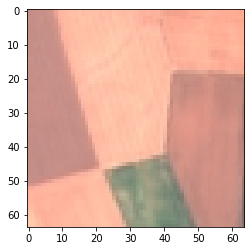

AnnualCrop.jpg
[{'HerbaceousVegetation': 0.36, 'River': 0.19, 'PermanentCrop': 0.12, 'Highway': 0.11, 'Pasture': 0.08, 'AnnualCrop': 0.06, 'Industrial': 0.03, 'Residential': 0.02, 'Forest': 0.01, 'SeaLake': 0.01}] 




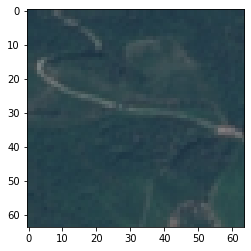

Forest.jpg
[{'Highway': 0.27, 'HerbaceousVegetation': 0.23, 'River': 0.12, 'PermanentCrop': 0.1, 'AnnualCrop': 0.08, 'Pasture': 0.08, 'Industrial': 0.04, 'Residential': 0.03, 'SeaLake': 0.03, 'Forest': 0.01}] 




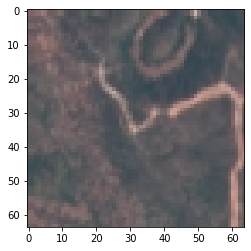

HerbaceousVegetation.jpg
[{'HerbaceousVegetation': 0.36, 'Highway': 0.18, 'River': 0.16, 'PermanentCrop': 0.1, 'Pasture': 0.09, 'Industrial': 0.04, 'AnnualCrop': 0.03, 'SeaLake': 0.02, 'Forest': 0.01, 'Residential': 0.01}] 




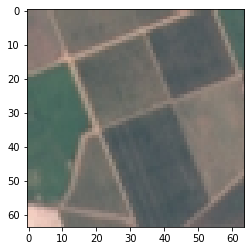

PermanentCrop.jpg
[{'HerbaceousVegetation': 0.36, 'PermanentCrop': 0.19, 'River': 0.14, 'Pasture': 0.11, 'Highway': 0.09, 'AnnualCrop': 0.05, 'SeaLake': 0.03, 'Residential': 0.02, 'Forest': 0.01, 'Industrial': 0.01}] 




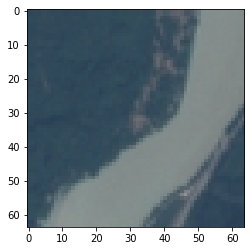

River.jpg
[{'Highway': 0.41, 'HerbaceousVegetation': 0.15, 'River': 0.14, 'PermanentCrop': 0.11, 'AnnualCrop': 0.1, 'Industrial': 0.03, 'Pasture': 0.02, 'Forest': 0.01, 'Residential': 0.01, 'SeaLake': 0.01}] 




In [4]:
img_urls = [
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/AnnualCrop.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/Forest.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/HerbaceousVegetation.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/PermanentCrop.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/River.jpg'
]

for img_url in img_urls:
    img = imageio.imread(img_url)
    results = model.predict(img)
    plt.imshow(img)
    plt.show()
    print(img_url.split('/')[-1])
    print(results, '\n\n')

## Image transformers

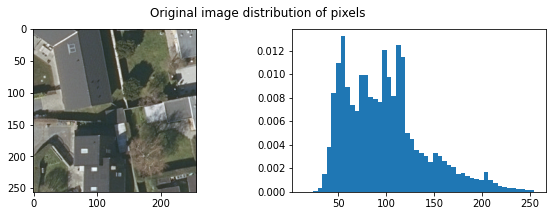

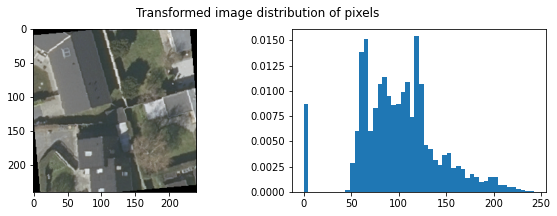

In [40]:
# this method sets model.mean and model.std
model.configure_preprocess()

# input size of images
input_size = (240, 240)

# creating a preprocessing + data augmentation unit for the training data
train_tt = tt.Compose([
    tt.Resize(input_size),
    tt.ColorJitter(brightness=0.15, contrast=0.33, saturation=0.2, hue=0.05),
    tt.RandomRotation(degrees=15),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomVerticalFlip(p=0.5),
    # tt.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 0.1)),
    # tt.RandomPerspective(distortion_scale=0.1, p=0.2),
    # tt.RandomPosterize(bits=2),
])

# creating a preprocessing unit for the validation data
val_tt = tt.Compose([
  tt.Resize(input_size)
])

# loading an image sample
# '../../../mnt/c/Users/dimit/Downloads/training_patches/training_patches/background/1G52LP.png'
img = Image.open('/content/training_patches/pools/4B37MU.png')

# lets have a look at the original image and its pixels values distribution
plt.rcParams['figure.figsize'] = (10,3)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[1].hist(np.asarray(img).ravel(), bins=50, density=True)
plt.suptitle('Original image distribution of pixels')
plt.show()

# using the preprocessing operations to transform the image to a pytorch tensor
img_tt = train_tt(img)
 
# lets have a look at the trasnformed image and its pixels values distribution
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_tt)
axs[1].hist(np.asarray(img_tt).ravel(), bins=50, density=True)
plt.suptitle('Transformed image distribution of pixels')
plt.show()

## Hyperparameters

In [11]:
hparams = {
    'learning_rate': 1e-2,
    'momentum':      0.9,
    'weight_decay':  3e-4,
    'gamma':         0.5,
    'ratio':         10,
    'milestones':    [1, 10, 20, 50, 100],
    'max_epoch':     10,
    'batch_size':    64,
    'criterion':     'cross_entropy',
    'optimizer':     'adam',
    'device':        torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
}

## Loading dataset

We need to create our own Dataset class that inherit torch.Dataset in order to create a torch.utils.data.DataLoader and fine tune the model. 

To do this, modify this code: https://github.com/canturan10/satellighte/blob/master/satellighte/datasets/eurosat.py

In [61]:
class CustomDataset(sat.datasets.base.BaseDataset):
    
    def __init__(self, root_dir, transforms):
        self.root_dir   = root_dir
        self.transforms = transforms
        ids, targets    = self._get_dataset()
        super().__init__(ids, targets, transforms=transforms)

    @property
    def num_classes(self):
        return len(self.__classes)

    @property
    def classes(self):
        return self.__classes

    def name_to_id(self, name: str):
        return self.__classes.index(name)

    def id_to_name(self, idx):
        return self.__classes[idx]

    def _get_dataset(self):
        targets = []
        ids     = []
        
        for class_path in self.root_dir.iterdir():
            if class_path.is_file():
                continue
            for img_path in class_path.iterdir():
                if img_path.suffix != '.png':
                    continue
                ids.append(img_path)
                targets.append(class_path.name)
                
        ids     = np.asarray(ids)
        targets = np.asarray(targets)

        targets = targets[ids.argsort()]
        ids     = ids[ids.argsort()]
        
        label_encoder = LabelEncoder()
        label_encoder.fit(np.sort(np.unique(targets)))
        labels = label_encoder.transform(targets)
        labels = np.asarray(targets)
        
        self.__classes = list(label_encoder.classes_)
            
        return ids.tolist(), labels.tolist()

In [68]:
# train dataset
train_ds = CustomDataset(
    # '../../../mnt/c/Users/dimit/Downloads/training_patches/training_patches/'
    root_dir   = Path('/content/drive/MyDrive/training_patches'),
    transforms = train_tt
)

# val dataset
val_ds = CustomDataset(
    # '../../../mnt/c/Users/dimit/Downloads/unlabeled_training_data/validation_labeled_data_0FRGJD/'
    root_dir   = Path('/content/drive/MyDrive/validation_labeled_data_0FRGJD'),
    transforms = train_tt
)

# creating DataLoader for training
train_dl = DataLoader(
    train_ds,
    batch_size = hparams.get('batch_size'),
    shuffle    = True,
)

# creating DataLoader for valdiation
val_dl = DataLoader(
    val_ds,
    batch_size = hparams.get('batch_size'),
    shuffle    = True,
)

#### Sanity check

In [76]:
print(train_ds.classes)
print(val_ds.classes)
print(len(train_ds.ids))
print(len(val_ds.ids))
print(train_ds.ids[-1:])
print(val_ds.ids[-1:])

['background', 'ponds', 'pools', 'solar', 'trampoline']
['background', 'pools', 'pounds', 'solar', 'trampoline']
3316
171
[PosixPath('../../../mnt/c/Users/dimit/Downloads/training_patches/training_patches/trampoline/ZF7XNU.png')]
[PosixPath('../../../mnt/c/Users/dimit/Downloads/unlabeled_training_data/validation_labeled_data_0FRGJD/trampoline/851.png')]


## Setting training environment

In [ ]:
# adding the metric we'd like to measure while the epochs go on
model.add_metric(
    'balanced_accuracy',
    tm.Accuracy(
        num_classes = len(train_ds.classes),
        average     = 'weighted'
    )
)

In [ ]:
 # define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath    = '/content/drive/MyDrive/task_2_models_checkpoint', # path to save the model
    filename   = 'task_2_model_checkpoint_dense_layers',            # filename to save the model
    monitor    = 'metrics/balanced_accuracy',                       # metric to monitor
    mode       = 'max',                                             # save max metric value
    save_top_k = 3,                                                 # number of models to keep
    verbose    = True,                                              # print information about the model checkpointing
)

In [ ]:
# define trainer
trainer = pl.Trainer(
    default_root_dir        = '/content/drive/MyDrive/', # Default path for logs and weights
    accelerator             = 'gpu',                     # gonna need GPU
    gpus                    = hparams.get('device'),     # GPU device
    max_epochs              = hparams.get('max_epoch'),  # stop training once this number of epochs is reached
    accumulate_grad_batches = 4,                         # accumulates grads every k batches 
    check_val_every_n_epoch = 1,                         # check validation every n train epochs.
    deterministic           = True,                      # set to True to disable randomness in the model
    callbacks               = [                          # callback for checkpointing
        checkpoint_callback,
        pl.callbacks.RichProgressBar(),
    ],  
)

## Modifying top layers to fit 5 classes instead of 10

In [ ]:
model.model.backbone.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=1280, out_features=100, bias=True),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(in_features=100, out_features=5, bias=True)
)

In [ ]:
# need this command to turn on dropout layers during training
model.train()

# freezing parameters
for parameter in model.parameters():
    parameter.requires_grad = False

# unfreezing dense layers
for parameter in model.model.backbone.classifier.parameters():
    parameter.requires_grad = True

## Fitting top layers

In [ ]:
# fit the model
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=[val_dl])

## Fine tuning all parameters

In [ ]:
del checkpoint_callback, trainer

In [ ]:
# define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath    = '/content/drive/MyDrive/task_2_models_checkpoint', # path to save the model
    filename   = 'task_2_model_checkpoint_all_layers',              # filename to save the model
    monitor    = 'metrics/balanced_accuracy',                       # metric to monitor
    mode       = 'max',                                             # save max metric value
    save_top_k = 3,                                                 # number of models to keep
    verbose    = True,                                              # print information about the model checkpointing
)

# define trainer
trainer = pl.Trainer(
    default_root_dir        = '/content/drive/MyDrive/', # Default path for logs and weights
    accelerator             = 'gpu',                     # gonna need GPU
    gpus                    = hparams.get('device'),     # GPU device
    max_epochs              = hparams.get('max_epoch'),  # stop training once this number of epochs is reached
    accumulate_grad_batches = 4,                         # accumulates grads every k batches 
    check_val_every_n_epoch = 1,                         # check validation every n train epochs.
    deterministic           = True,                      # set to True to disable randomness in the model
    callbacks               = [                          # callback for checkpointing
        checkpoint_callback,
        pl.callbacks.RichProgressBar(),
    ],  
)

In [ ]:
model.train()

for parameter in model.parameters():
    parameter.requires_grad = True

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=[val_dl])